## **Analyze** uConnect

**Required Imports**

In [ ]:
import sys

import geopandas as gpd
import matplotlib
import numpy as np
import pandas as pd

sys.path.append('../../')
import src

**Load Data & Results**

In [52]:
degree_sequences_data = pd.read_parquet("../../data/uconnect/processed/degree_sequences_uconnect.parquet")
population_density_data = gpd.read_file("../../data/uconnect/processed/population_density_uconnect.geojson")

In [53]:
mencommreg = degree_sequences_data["degree_sequence"].iloc[0]
numpars1 = degree_sequences_data["degree_sequence"].iloc[1]

In [54]:
filepath = "../../results/uconnect"
filename = "2025-07-24_uconnect_duration-7290_samples-100"

In [55]:
metadata = pd.read_parquet(f"{filepath}/{filename}_metadata.parquet")
metrics = pd.read_parquet(f"{filepath}/{filename}_metrics.parquet")
distributions = pd.read_parquet(f"{filepath}/{filename}_distributions.parquet")
locations = np.load(f"{filepath}/{filename}_locations.npy")

In [56]:
metadata["char_dist"] = np.array(metadata["char_dist"] / 5280, dtype=int)
dataframe = metadata.merge(metrics, on=["unique_id"], how="left")

**Compute Metrics**

In [57]:
dataframe = src.data.proportion_of_dropped_edges(dataframe=dataframe)
dataframe = src.data.number_of_overlap_edges_to_number_of_net1_edges(dataframe=dataframe)
dataframe = src.data.number_of_overlap_edges_to_number_of_net2_edges(dataframe=dataframe)
dataframe = src.data.normalized_global_jaccard(dataframe=dataframe)

In [58]:
distributions = src.data.joint_deg_mean_number_of_overlap_edges(dataframe=distributions)
distributions = src.data.joint_deg_mean_number_of_overlap_edges_to_number_of_net1_edges(dataframe=distributions)
distributions = src.data.joint_deg_mean_number_of_overlap_edges_to_number_of_net2_edges(dataframe=distributions)
distributions = src.data.joint_deg_mean_normalized_local_jaccard(dataframe=distributions)

**Set Colors**

In [59]:
blues = matplotlib.colormaps.get_cmap("Blues")
oranges = matplotlib.colormaps.get_cmap("Oranges")

cms_color = matplotlib.colors.to_hex(oranges(0.50))
sdc_color = matplotlib.colors.to_hex(blues(0.50))
sdcdp_color = matplotlib.colors.to_hex(blues(1.00))
palette = {"CMS": cms_color, "SDC": sdc_color, "SDC-DP": sdcdp_color}

**Plot Locations**

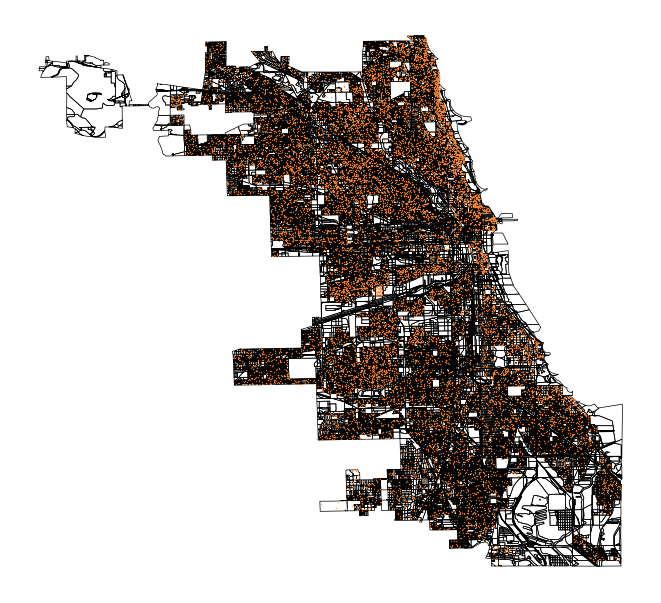

In [60]:
fig1 = src.plots.plot_geographic_locations(population_density_data, locations, color=cms_color)

display(fig1)

**Plot Degree Distributions**

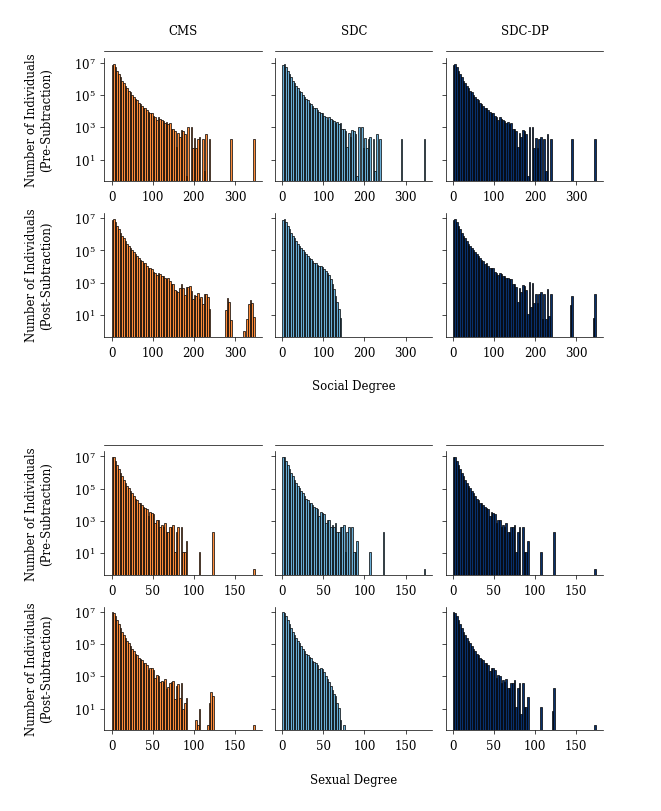

In [61]:
params = [
    {"rows": ["joint_deg_number_of_nodes_pre", "joint_deg_number_of_nodes_post"], "repeat": True},
    {"rows": ["joint_deg_number_of_nodes_pre", "joint_deg_number_of_nodes_post"], "repeat": True}
]

labels = [
    {"rows": ["Number of Individuals\n(Pre-Subtraction)", "Number of Individuals\n(Post-Subtraction)"], "columns": "Social Degree"},
    {"rows": ["Number of Individuals\n(Pre-Subtraction)", "Number of Individuals\n(Post-Subtraction)"], "columns": "Sexual Degree"}
]

binsizes = [
    4,
    2
]

binby = [
    "deg1",
    "deg2"
]

fig2 = src.plots.plot_joint_degree_distributions(distributions, params, labels, binsizes, binby, refine=None, log=True, density=False, palette=palette)

display(fig2)

**Plot Global Overlap**

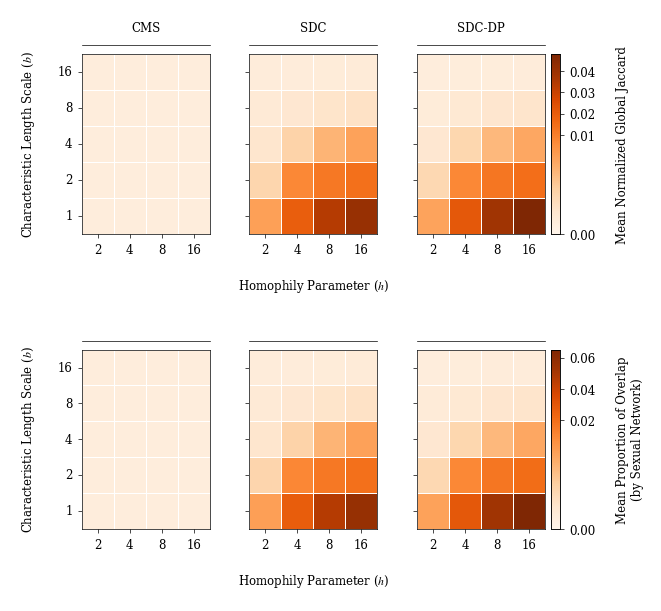

In [62]:
params = [
    {"rows": "char_dist", "columns": "homophily", "value": "normalized_global_jaccard"},
    {"rows": "char_dist", "columns": "homophily", "value": "number_of_overlap_edges_to_number_of_net2_edges"}
]

labels = [
    {"rows": r"Characteristic Length Scale ($b$)", "columns": r"Homophily Parameter ($h$)", "value": "Mean Normalized Global Jaccard"},
    {"rows": r"Characteristic Length Scale ($b$)", "columns": r"Homophily Parameter ($h$)", "value": "Mean Proportion of Overlap\n(by Sexual Network)"}
]

fig3 = src.plots.plot_global_metrics(dataframe, params, labels, refine=None, aggfunc="mean", colormap=oranges)

display(fig3)

**Plot Local Overlap**

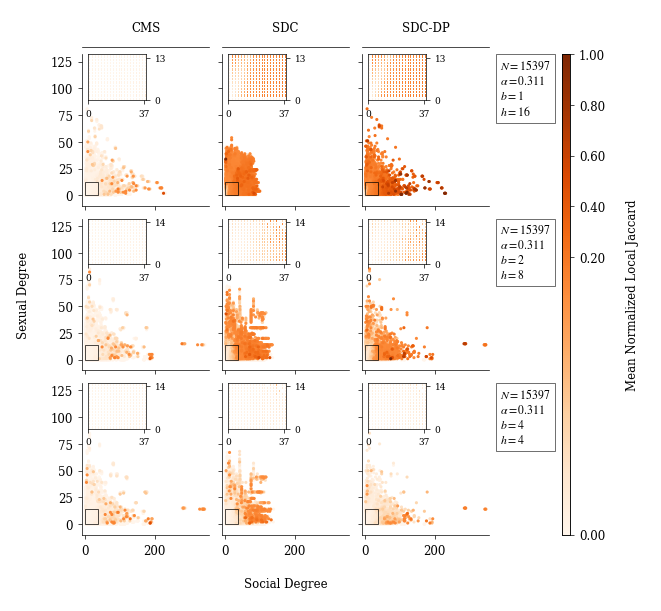

In [63]:
net_size = metadata["net_size"].unique()[0]
deg_seq_corr = metadata["deg_seq_corr"].unique()[0]
uid1 = src.data.get_unique_ids(metadata, net_size=net_size, deg_seq_corr=deg_seq_corr, char_dist=1, homophily=16)[0]
uid2 = src.data.get_unique_ids(metadata, net_size=net_size, deg_seq_corr=deg_seq_corr, char_dist=2, homophily=8)[0]
uid3 = src.data.get_unique_ids(metadata, net_size=net_size, deg_seq_corr=deg_seq_corr, char_dist=4, homophily=4)[0]

params = [
    {"unique_id": uid1, "legend": (net_size, deg_seq_corr.round(3), 1, 16)},
    {"unique_id": uid2, "legend": (net_size, deg_seq_corr.round(3), 2, 8)},
    {"unique_id": uid3, "legend": (net_size, deg_seq_corr.round(3), 4, 4)}
]

labels = {
    "rows": "Sexual Degree",
    "columns": "Social Degree",
    "value": "Mean Normalized Local Jaccard"
}

mode = "joint_deg_mean_normalized_local_jaccard"

fig4 = src.plots.plot_local_metrics(distributions, params, labels, mode, threshold=0.90, degs=("deg1", "deg2"), colormap=oranges)

display(fig4)

**Save Plots**

In [64]:
fig1.savefig(f"{filepath}/plots/locations_uconnect.pdf", format="pdf", dpi=300)
fig2.savefig(f"{filepath}/plots/degree_distributions_uconnect.pdf", format="pdf", dpi=300)
fig3.savefig(f"{filepath}/plots/global_overlap_uconnect.pdf", format="pdf", dpi=300)
fig4.savefig(f"{filepath}/plots/local_overlap_uconnect.pdf", format="pdf", dpi=300)